In [32]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import sys
sys.path.append(r'C:\Users\yuhan\nanospheres\src')
from utils import load_timestreams, get_psd
from get_sphere_charge import peak_func, fit_peak

In [33]:
from cycler import cycler
colors=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004']
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (7, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

In [34]:
data_dir = r"D:\calibration"
prefix = r"20240802_3e_2_5vp2p_97khz_5e-8mbar"
file = glob.glob(f"{data_dir}\{prefix}.mat")[0]

dtt, tt, nn = load_timestreams(file, ['D'])

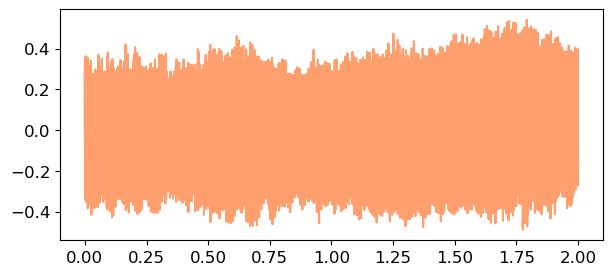

In [35]:
plt.plot(tt, nn[0])

Text(0.5, 1.0, 'Pressure = $3.7 \\times 10^{-8}$ mbar')

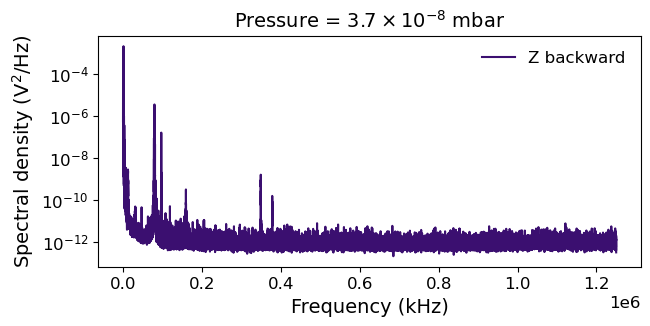

In [36]:
ffzb, ppzb= get_psd(dtt, None, nn[0], nperseg=500000)

# plt.plot(ffz, ppz, label='Z forward', color=colors[2])
plt.plot(ffzb, ppzb, label='Z backward', color=colors[3])

plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (V$^2$/Hz)')
plt.title(r'Pressure = $3.7 \times 10^{-8}$ mbar')

## Fit a Lorentzian peak to the backscatter z

In [37]:
def log_peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return np.log(amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 ))

C:\Users\yuhan\AppData\Local\Temp\ipykernel_18188\2674183824.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 ))


[5.94278944e+07 5.01069903e+05 1.06339171e+02]


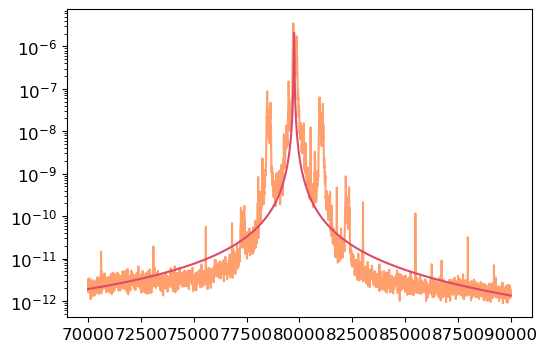

In [38]:
passband = (70000, 90000)
all_idx = np.logical_and(ffzb > passband[0], ffzb < passband[1])

p0=[2e8, 80000*2*np.pi, 50]
popt, omega_fit, p_fit = fit_peak(ffzb[all_idx]*2*np.pi, np.log(ppzb[all_idx]), log_peak_func, p0=p0)
amp, omega0, gamma = popt[0], popt[1], popt[2]
print(popt)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ffzb[all_idx], ppzb[all_idx])
ax.plot(omega_fit/(2*np.pi), np.exp(p_fit))
ax.set_yscale('log')

In [39]:
def get_area_driven(ff, pp, passband=(96970, 97030), plot=True):
    idx = np.logical_and(ff > passband[0], ff < passband[1])
    area_all = np.trapz(pp[idx], ff[idx]*2*np.pi)
    v2_drive = area_all / (2 * np.pi)

    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(ffzb[idx], ppzb[idx])
    
    return v2_drive

In [40]:
def get_cal_factor_driven(charge, vp2p, drive_freq, v2_drive):
    rho = 2000 # kg/m^3
    r   = 166e-9 / 2
    m   = rho * (4 * np.pi / 3) * r**3

    efield_sim = 120
    omega_drive = drive_freq * 2 * np.pi
    
    f0 = charge * 1.6e-19 * efield_sim * (vp2p / 2)
    x2_drive = f0**2 / ((2 * m**2) * ( (omega0**2 - omega_drive**2)**2 + gamma**2 * omega_drive**2))

    c_cal_square = v2_drive / x2_drive
    
    return c_cal_square

Calibration factor c_cal_square = 160888032841252.19


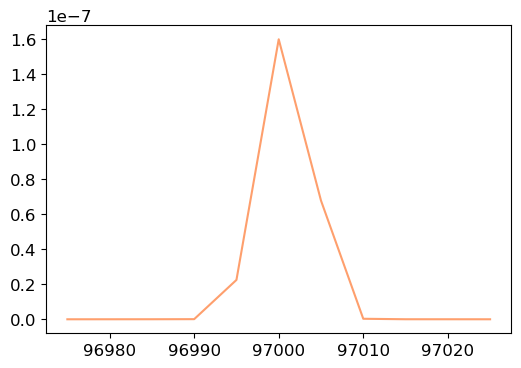

In [41]:
v2_drive = get_area_driven(ffzb, ppzb, passband=(96970, 97030))
c_cal_square = get_cal_factor_driven(3, 2.5, 97000, v2_drive)
print(f'Calibration factor c_cal_square = {c_cal_square:.2f}')

In [42]:
v2_drive_f = get_area_driven(ffz, ppz)
c_cal_square_f = get_cal_factor_driven(2, 5, 91000, v2_drive_f)
print(f'Calibration factor c_cal_square = {c_cal_square_f:.2f}')

NameError: name 'ffz' is not defined

Text(0.5, 1.0, 'Pressure = $5 \\times 10^{-8}$ mbar')

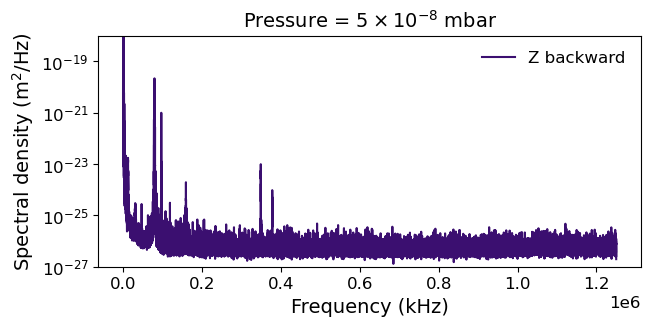

In [43]:
# plt.plot(ffz, ppz/c_cal_square_f, label='Z forward', color=colors[2])
plt.plot(ffzb, ppzb/c_cal_square, label='Z backward', color=colors[3])

plt.yscale('log')
plt.ylim(1e-27, 1e-18)
plt.legend(frameon=False)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (m$^2$/Hz)')
plt.title(r'Pressure = $5 \times 10^{-8}$ mbar')

## Load data with no driving field

In [127]:
data_dir = r"D:\calibration"
prefix = r"20240719_noefield_3_7e-8mbar"
file = glob.glob(f"{data_dir}\{prefix}.mat")[0]

dtt, tt, nn = load_timestreams(file, ['C', 'D'])

In [128]:
ffz, ppz= get_psd(dtt, None, nn[0], nperseg=10000)
ffzb, ppzb= get_psd(dtt, None, nn[1], nperseg=10000)

Text(0.5, 1.0, 'Pressure = $3.7 \\times 10^{-8}$ mbar')

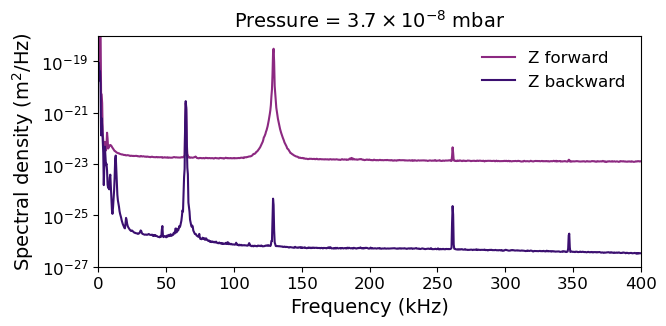

In [130]:
plt.plot(ffz/1000, ppz/c_cal_square_f, label='Z forward', color=colors[2])
plt.plot(ffzb/1000, ppzb/c_cal_square, label='Z backward', color=colors[3])

plt.yscale('log')
plt.ylim(1e-27, 1e-18)
plt.xlim(0, 400)
plt.legend(frameon=False)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density (m$^2$/Hz)')
plt.title(r'Pressure = $3.7 \times 10^{-8}$ mbar')